# **Art Analytics: Exploring the MET Dataset with SQL and BigQuery**



## Author
* Lara Selin Seyahi
seyahi@stanford.edu

## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user() # make sure to "Select All" when authenticating
project_id = "cs145-project-fall24"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# Query 1
# Key question 1: What are the top 10 art departments with the most amount of artifacts?

%%bigquery --project cs145-project-fall24
SELECT DISTINCT department, COUNT(*) as total_works_of_art
FROM `bigquery-public-data.the_met.objects`
GROUP BY department
ORDER BY total_works_of_art DESC
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,department,total_works_of_art
0,Drawings and Prints,43488
1,European Sculpture and Decorative Arts,30611
2,Asian Art,29844
3,Greek and Roman Art,12518
4,Egyptian Art,12278
5,Islamic Art,10435
6,American Decorative Arts,8942
7,Costume Institute,7824
8,Medieval Art,6838
9,Photographs,6583


In [ ]:
%%bigquery departments_table --project cs145-project-fall24
SELECT DISTINCT department, COUNT(*) as total_works_of_art
FROM `bigquery-public-data.the_met.objects`
GROUP BY department
ORDER BY total_works_of_art DESC
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

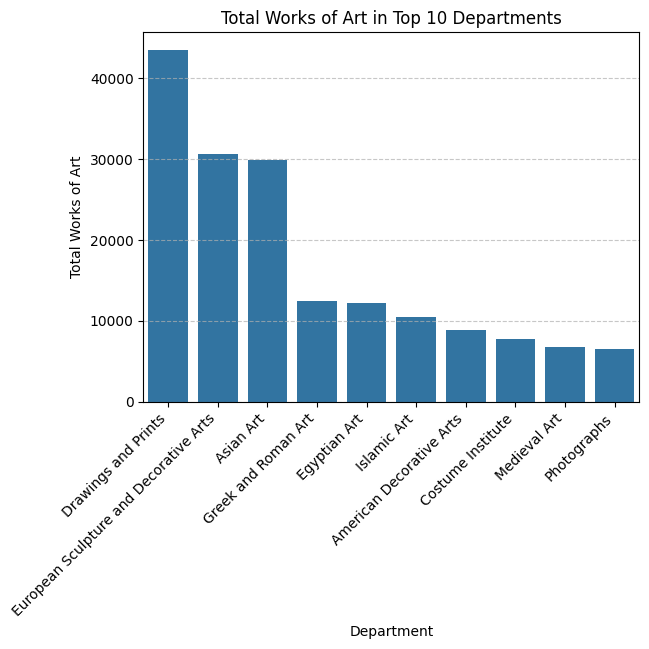

In [ ]:
# Key question 1: Data Visualization
sns.barplot(x=departments_table.department, y=departments_table.total_works_of_art)
plt.xlabel('Department')
plt.ylabel('Total Works of Art')
plt.title('Total Works of Art in Top 10 Departments')
plt.xticks(rotation=45, ha='right')  # ha='right' ensures labels are aligned to the right
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Customize line style and transparency

In [ ]:
%%bigquery --project cs145-project-fall24
# Query 2
# Key question 2: What are the top labels (art object type) asscociated with each department? What's the percentage ratio of the top label to all labels within each department?

# CTE that joins the api data and object tables together
# ranks the artistic representation type by the number they exist in within each department
WITH
APIdata AS (
  SELECT label.description as representation, object_id
  # labelAnnotations is a nested structure, UNNEST function flattens the array and gives separate rows for each of its elements
  FROM `bigquery-public-data.the_met.vision_api_data`, UNNEST(labelAnnotations) as label),
  # CTE that counts how often each artistic representation appears in each department and order them by count
RepresentationsInDepartments AS(
  SELECT department, representation, COUNT(*) as count, ROW_NUMBER() OVER (PARTITION BY department ORDER BY COUNT(*) DESC) as rank
  FROM `bigquery-public-data.the_met.objects` as objects
  JOIN APIdata
  ON APIdata.object_id = objects.object_id
  WHERE department is not NULL and representation != 'art' # removing art shows the mediums
  GROUP BY department, representation
),
# CTE for counting the total number of labels associated with each department, which will be used in the ratio calculation of label per department
TotalCounts AS(
  SELECT department, representation, count, SUM(count) OVER (PARTITION BY department) as total_count_per_dep, rank
  FROM RepresentationsInDepartments
  GROUP BY department, representation, count, rank
)
# selecting the top  artistic representation type per department
SELECT department, representation, (count / total_count_per_dep) * 100 as representation_ratio_per_department
FROM TotalCounts
WHERE rank = 1
ORDER BY count desc;


Query is running:   0%|          |

Downloading:   0%|          |

,department,representation,representation_ratio_per_department
0,Drawings and Prints,sketch,18.257860
1,European Sculpture and Decorative Arts,pattern,5.907496
2,Asian Art,pattern,5.128574
3,Costume Institute,clothing,13.641765
4,Greek and Roman Art,ceramic,7.286199
5,Photographs,photograph,10.685688
6,Egyptian Art,sculpture,5.800524
7,Islamic Art,pattern,6.739927
8,American Paintings and Sculpture,sketch,10.016986
9,American Decorative Arts,black and white,4.167680


In [ ]:
%%bigquery --project cs145-project-fall24

# Query 3
# Key Question 3: Which departments are the most similar in terms of the art mediums they create?

# CTE for creating a table for that includes all department and art medium pairs
With MediumsAndDepartments AS(
  SELECT department, label.description as medium
  FROM `bigquery-public-data.the_met.vision_api_data` as api_data, UNNEST(labelAnnotations) as label
  JOIN `bigquery-public-data.the_met.objects` as objects
  # joining them on the object id
  ON objects.object_id = api_data.object_id
  WHERE medium is not NULL and department is not NULL
  GROUP BY department, medium
)

# calculating similarity between departments in terms of the number of overlapping mediums that they have
SELECT table1.department as department1, table2.department as department2, COUNT(*) as MatchingMediums
FROM MediumsAndDepartments as table1
JOIN MediumsAndDepartments as table2
# matching the mediums, and putting the first table first to prevent duplicates
ON table1.medium = table2.medium and table1.department < table2.department
GROUP BY table1.department, table2.department
ORDER BY MatchingMediums DESC
LIMIT 20;


Query is running:   0%|          |

Downloading:   0%|          |

,department1,department2,MatchingMediums
0,Asian Art,European Sculpture and Decorative Arts,630
1,Asian Art,Egyptian Art,534
2,American Decorative Arts,European Sculpture and Decorative Arts,502
3,Egyptian Art,European Sculpture and Decorative Arts,499
4,Asian Art,Islamic Art,494
5,Asian Art,Medieval Art,484
6,European Sculpture and Decorative Arts,Islamic Art,482
7,European Sculpture and Decorative Arts,Medieval Art,474
8,American Decorative Arts,Asian Art,470
9,Asian Art,Greek and Roman Art,454


In [ ]:
%%bigquery --project cs145-project-fall24

# Query 4
# Key question 4: "How do Wikipedia page visits in the first half of 2024 related to the top 10 art departments reflect public interest in specific artworks or cultural topics?"
SELECT
    # conditional expression
    CASE
        # REGEXP_CONTAINS function checks if the wiki.title matches with a regular expression for each department name,
        # if so, assigned it to the corresponding department name
        WHEN REGEXP_CONTAINS(wiki.title, r'Drawings_and_Prints') THEN 'Drawings and Prints'
        WHEN REGEXP_CONTAINS(wiki.title, r'European_Sculpture_and_Decorative_Arts') THEN 'European Sculpture and Decorative Arts'
        WHEN REGEXP_CONTAINS(wiki.title, r'Asian_Art') THEN 'Asian Art'
        WHEN REGEXP_CONTAINS(wiki.title, r'Greek_and_Roman_Art') THEN 'Greek and Roman Art'
        WHEN REGEXP_CONTAINS(wiki.title, r'Egyptian_Art') THEN 'Egyptian Art'
        WHEN REGEXP_CONTAINS(wiki.title, r'Islamic_Art') THEN 'Islamic Art'
        WHEN REGEXP_CONTAINS(wiki.title, r'American_Decorative_Arts') THEN 'American Decorative Arts'
        WHEN REGEXP_CONTAINS(wiki.title, r'Costume_Institute') THEN 'Costume Institute'
        WHEN REGEXP_CONTAINS(wiki.title, r'Medieval_Art') THEN 'Medieval Art'
        WHEN REGEXP_CONTAINS(wiki.title, r'Photographs') THEN 'Photographs'
    END AS department_label, # The corresponding department label for the title
    SUM(wiki.views) AS total_pageviews
FROM
    `bigquery-public-data.wikipedia.pageviews_2024` AS wiki
WHERE
    REGEXP_CONTAINS(wiki.title, r'(Drawings_and_Prints|European_Sculpture_and_Decorative_Arts|Asian_Art|Greek_and_Roman_Art|Egyptian_Art|Islamic_Art|American_Decorative_Arts|Costume_Institute|Medieval_Art|Photographs)')
    AND wiki.datehour >= '2024-01-01'  # start date
    AND wiki.datehour < '2024-06-01'  # end date
GROUP BY
    department_label
ORDER BY
    total_pageviews DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,department_label,total_pageviews
0,Photographs,1101793
1,Islamic Art,65296
2,Asian Art,35919
3,Costume Institute,16611
4,Egyptian Art,3996
5,Greek and Roman Art,2405
6,Medieval Art,1517
7,Drawings and Prints,755
8,American Decorative Arts,600
9,European Sculpture and Decorative Arts,506


In [ ]:
%%bigquery --project cs145-project-fall24

# Query 5
# Supplementary Question 1: What is the most represents period and culture in each department?

SELECT department, period, culture, total_works
# subquery for creating a table where periods and cultures within each department are ranked by the number of appreance
FROM (
  SELECT department, period, culture, COUNT(*) as total_works, RANK() OVER (PARTITION BY department ORDER BY COUNT(*) DESC) as rank
  FROM `bigquery-public-data.the_met.objects`
  WHERE department is not NULL
  GROUP BY department, period, culture
) AS all_works
# selecting the top period and culture for each department
WHERE rank = 1;



Query is running:   0%|          |

Downloading:   0%|          |

,department,period,culture,total_works
0,American Paintings and Sculpture,None,None,4783
1,American Decorative Arts,None,American,6102
2,Photographs,None,None,6583
3,Asian Art,Edo period (1615–1868),Japan,8053
4,Costume Institute,None,American,2969
5,Greek and Roman Art,None,None,999
6,European Sculpture and Decorative Arts,None,French,5255
7,Ancient Near Eastern Art,Sasanian,Sasanian,906
8,The Cloisters,None,French,869
9,Arms and Armor,None,Japanese,1419


In [ ]:
%%bigquery --project cs145-project-fall24

# Query 6
# Supplementary question 2: What is the most common object type in each department? What percentage of the department's total does this object type represent?
# CTE for counting the total number of objects in each department and ranking the objects by the number they exist in, in each department
WITH RankedObjects AS (
  SELECT department, object_name, COUNT(*) as total_works, RANK() OVER (PARTITION BY department ORDER BY COUNT(*) DESC) AS rank
  FROM `bigquery-public-data.the_met.objects`
  WHERE object_name is not NULL
  GROUP BY department, object_name
),
# CTE for creating ratios of object count to total object count in each department
RatioOfRankedObjects AS (
  SELECT department, object_name, total_works, rank, SUM(total_works) OVER (PARTITION BY department) AS total_works_department
  FROM RankedObjects
)

# selecting the object that appears the most in each department,
# and reporting the count of the object per department, total object count in the department, and what percent of the department is composed of that object
SELECT department, object_name, total_works, total_works_department, (total_works / total_works_department) * 100 as object_per_department_percentage
FROM RatioOfRankedObjects
WHERE rank = 1
ORDER BY object_per_department_percentage desc;


Query is running:   0%|          |

Downloading:   0%|          |

,department,object_name,total_works,total_works_department,object_per_department_percentage
0,Photographs,Photograph,5096,6579,77.458580
1,European Paintings,Painting,1781,2322,76.701120
2,Drawings and Prints,Print,22464,43457,51.692478
3,Modern and Contemporary Art,Drawing,496,1108,44.765343
4,American Paintings and Sculpture,Drawing,1912,4783,39.974911
5,Islamic Art,Fragment,3497,10435,33.512218
6,Robert Lehman Collection,Drawing,674,2410,27.966805
7,Medieval Art,Fragment,1442,6836,21.094207
8,Ancient Near Eastern Art,Stamp seal,899,6171,14.568141
9,"Arts of Africa, Oceania, and the Americas",Ornament,793,6021,13.170570


In [ ]:
%%bigquery --project cs145-project-fall24

# Query 7
# Supplementary question 3: Who are the artists with the highest number of works in each department?

# CTE for assigning a row number for each artist within each department based on the number of objects they have
WITH RankedArtists AS (
  SELECT artist_display_name, department, COUNT(*) as num_works, ROW_NUMBER() OVER (PARTITION BY department ORDER BY COUNT(*) DESC) AS rank
  FROM `bigquery-public-data.the_met.objects`
  WHERE artist_display_name is not NULL
  GROUP BY department, artist_display_name
)
SELECT department, artist_display_name, num_works
FROM RankedArtists
WHERE rank = 1
ORDER BY num_works desc;


Query is running:   0%|          |

Downloading:   0%|          |

,department,artist_display_name,num_works
0,Drawings and Prints,Allen & Ginter,2908
1,Photographs,Unknown,757
2,Asian Art,Utagawa Hiroshige,668
3,American Paintings and Sculpture,John Singer Sargent,622
4,European Sculpture and Decorative Arts,Meissen Manufactory,466
5,American Decorative Arts,Union Porcelain Works,136
6,Islamic Art,Abu'l Qasim Firdausi,118
7,Robert Lehman Collection,Chinese,99
8,Modern and Contemporary Art,Paul Klee,97
9,Costume Institute,Jeanne Lanvin|House of Lanvin,91


In [ ]:
%%bigquery --project cs145-project-fall24
#Query 8
# Anomalies in the dataset question: How do mediums used change across artists from different nationalities?

# The results of this query reveal a limitation:
# the labels in artist_nationalities in the table could be more specific and unique

WITH
# CTE for api data that only including label and object id
APIdata AS (
  SELECT label.description as label, object_id
  FROM `bigquery-public-data.the_met.vision_api_data`, UNNEST(labelAnnotations) label),

# CTE for object data that only including artist nationality and object id
ObjectInfo AS (
  SELECT artist_nationality, object_id
  FROM `bigquery-public-data.the_met.objects`
  WHERE artist_nationality is not NULL
)

# table where APIdata and ObjectInfo are joined ob object id,
# labels within each nationality is assigned row numbers based on the number of labels
SELECT artist_nationality, label, label_count
FROM (
  SELECT  artist_nationality, label, COUNT(*) as label_count, ROW_NUMBER() OVER(PARTITION BY artist_nationality ORDER BY COUNT(*) DESC) as rank
  FROM APIdata JOIN ObjectInfo
  ON APIdata.object_id = ObjectInfo.object_id
  GROUP BY artist_nationality, label
)
WHERE rank = 1
ORDER BY artist_nationality;



Query is running:   0%|          |

Downloading:   0%|          |

,artist_nationality,label,label_count
0,Aachen,weapon,1
1,Africa,material,1
2,Algerian|Italian|Italian|Italian|Italian,text,1
3,American,sketch,5178
4,American German,sketch,4
...,...,...,...
1075,Veronese,painting,1
1076,active in France by 1894|French,sketch,1
1077,possibly French,structure,1
1078,possibly Iranian,weapon,1


In [ ]:
%%bigquery --project cs145-project-fall24
# Query 9
# Significant features in the dataset question:
# For which artworks, is the "Suprise Likelihood Label" under face annotations exists?

# selecting rows where label for surprised face is labelled very likely
SELECT surpriseLikelihood, title, department
# faceAnnotations is a nested structure, unnest makes elements of it accessible by flattening the array into rows
FROM  `bigquery-public-data.the_met.vision_api_data` as api_data, UNNEST(faceAnnotations) as face
JOIN `bigquery-public-data.the_met.objects` as objects
ON objects.object_id = api_data.object_id
# select rows where face surprise likelihood is vey likely
WHERE face.surpriseLikelihood = "VERY_LIKELY";




Query is running:   0%|          |

Downloading:   0%|          |

,surpriseLikelihood,title,department
0,VERY_LIKELY,Two terracotta roundels with theatrical masks,Greek and Roman Art


In [ ]:
%%bigquery --project cs145-project-fall24
# Query 10
# Exploratory question: Which landmarks do photographers take photographs of are classified with the highest accuracy?

# CTE for selecting photographers in the Photography department and the object_ids
WITH EuropeanAndAmericanArtists AS (
  SELECT artist_display_name as photographer, object_id
  FROM `bigquery-public-data.the_met.objects`
  WHERE department = 'Photographs' and artist_display_name is not NULL
  GROUP BY artist_display_name, object_id
)

# showing the photographer, the location they took a picture of,
# ordered by the average score for classification accuracy for the location
SELECT photographer, locations.description as locations, AVG(locations.score) as avgScore
FROM `bigquery-public-data.the_met.vision_api_data` as api_data, UNNEST(landmarkAnnotations) as locations
JOIN EuropeanAndAmericanArtists
ON EuropeanAndAmericanArtists.object_id = api_data.object_id
GROUP BY photographer, locations
ORDER BY avgScore desc
LIMIT 10;



Query is running:   0%|          |

Downloading:   0%|          |

,photographer,locations,avgScore
0,Édouard Baldus,Panthéon,0.616616
1,Charles Clifford,Palacio de los Condes de Sástago,0.616468
2,Félix Teynard,Abu Simbel,0.615182
3,Gustave Le Gray,Temple of Edfu,0.596194
4,Édouard Baldus,Arc de Triomphe,0.586231
5,Underwood & Underwood|Benneville Lloyd Singley...,"Mesa Verde National Park, Cliff Palace",0.570765
6,Carleton E. Watkins,"Yosemite National Park, Yosemite Falls",0.559015
7,Eugène Constant,Basilica of St. John Lateran,0.540457
8,Eugène Constant,Saint Peter's Square,0.538823
9,Charles Clifford,Montserrat,0.523560


In [ ]:
%%bigquery --project cs145-project-fall24
# Query 11
# Exploratory question: Who are the top 5 artists in the American Paintings and Sculpture and in European Paintings departments with the highest number of works?

SELECT artist_display_name, department, rank, number_of_works
FROM (
  SELECT artist_display_name, department, count(*) as number_of_works, RANK() OVER(PARTITION BY department ORDER BY COUNT(*) desc) as rank
  FROM `bigquery-public-data.the_met.objects`
  WHERE department in ('American Paintings and Sculpture', 'European Paintings') and artist_display_name is not NULL
  GROUP BY artist_display_name, department
)
WHERE rank <= 5;

Query is running:   0%|          |

Downloading:   0%|          |

,artist_display_name,department,rank,number_of_works
0,John Singer Sargent,American Paintings and Sculpture,1,622
1,Thomas Sully,American Paintings and Sculpture,2,189
2,Albert Bierstadt,American Paintings and Sculpture,3,163
3,William Trost Richards,American Paintings and Sculpture,4,152
4,Mary Newbold Sargent,American Paintings and Sculpture,5,100
5,Edgar Degas,European Paintings,1,51
6,Claude Monet,European Paintings,2,39
7,French Painter,European Paintings,3,36
8,Camille Corot,European Paintings,4,32
9,Gustave Courbet,European Paintings,5,30


In [ ]:
%%bigquery --project cs145-project-fall24
# Query 12
# Trends question: What is the popularity of the most represented American artists in wikipedia searches in the first half of 2024?
# Is it the same ordering as the query above?

SELECT  COUNT(*) AS total_views, title
FROM
`bigquery-public-data.wikipedia.pageviews_2024`
WHERE
title IN ('John_Singer_Sargent', 'Thomas_Sully', 'Albert_Bierstadt', 'William_Trost_Richards','Mary_Newbold_Sargent')  -- Use OR logic
AND datehour >= '2024-01-01'
AND datehour < '2024-06-01'
GROUP BY title
ORDER BY total_views desc;



Query is running:   0%|          |

Downloading:   0%|          |

,total_views,title
0,33635,John_Singer_Sargent
1,15863,Albert_Bierstadt
2,4507,Thomas_Sully
3,2446,William_Trost_Richards


In [ ]:
%%bigquery --project cs145-project-fall24
# Query 13
# Exploratory question: What landmarks do prominent european painters in the European Paintings department draw?

# CTE for artist names and object ids only for the top artists in the European Paintings department
WITH EuropeanPaintings AS (
 SELECT artist_display_name, object_id
 FROM `bigquery-public-data.the_met.objects`
 WHERE artist_display_name in ('Edgar Degas', 'Claude Monet', 'Camille Corot', 'Gustave Courbet'))
SELECT artist_display_name, landmark.description as places,
FROM  `bigquery-public-data.the_met.vision_api_data` as api_data, UNNEST(landmarkAnnotations) as landmark
JOIN EuropeanPaintings
ON api_data.object_id = EuropeanPaintings.object_id;

Query is running:   0%|          |

Downloading:   0%|          |

,artist_display_name,places
0,Edgar Degas,New York City
1,Edgar Degas,New York City


In [ ]:
%%bigquery --project cs145-project-fall24
# Query 14
# Significant features in the dataset question
# What landmarks have the highest accuracy in detection and what departments and artists do they belong to?

SELECT landmark.score, landmark.description, department, artist_display_name
FROM `bigquery-public-data.the_met.vision_api_data` as api_data, UNNEST(landmarkAnnotations) as landmark
JOIN `bigquery-public-data.the_met.objects` as objects
ON objects.object_id = api_data.object_id
ORDER BY landmark.score DESC
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,score,description,department,artist_display_name
0,0.980163,Yosemite National Park,Photographs,Carleton E. Watkins
1,0.965158,Met Art,European Paintings,Vincent van Gogh
2,0.962197,Met Art,European Paintings,Vincent van Gogh
3,0.958862,Château de Malmaison,European Sculpture and Decorative Arts,baron François Gérard|Manufacture Nationale de...
4,0.957750,Metropolitan Museum of Art,European Paintings,Giovanni Battista Tiepolo
5,0.954218,New York City,European Paintings,Edgar Degas
6,0.954066,Metropolitan Museum of Art,European Paintings,Vincent van Gogh
7,0.942639,Met Art,European Paintings,Vincent van Gogh
8,0.939375,Metropolitan Museum of Art,European Paintings,Vincent van Gogh
9,0.935057,Munch Museum,Drawings and Prints,Edvard Munch


## Conclusion

---

1. Summary of what was learned from the data (5 points).

The data revealed that important highlights about the Metropolitan Museum of Art. The departments with the highest counts of artifacts are Drawings and Prints with 43488 objects, European Sculpture and Decorative Arts with 30611 objects, Asian Art with 29844 objects, Greek and Roman Art with	12518 objects, and Egyptian Art with	12278 objects.

While sketches appear the most in European Sculpture and Decorative Arts, patterns appear the most in European Sculpture and Decorative Arts and Asian Art, followed by clothing in Costume Institute, ceramic in Greek and Roman Art, photograph in Photographs, and sculpture	in Egyptian Art.

The department pairs that are the most similar in terms of the number of art mediums they both create are Asian Art	and European Sculpture and Decorative Arts departments with 630  mediums shared between them, followed by Asian Art	and Egyptian Art with	534 mediums, followed by American Decorative Arts	and European Sculpture and Decorative Arts	with 502 medium, followed by Egyptian Art	and European Sculpture and Decorative Arts	departments with 499 mediums, and Asian Art	and Islamic Art departments with 494 mediums.

In the wikipedia searches from the first half of 2024, when the number of searches of titles relevant to the departments are investigated. In the titles searched for, Photographs appears the most, followed by Islamic Art, and Asian Art. The ordering of ranking of searches is different from the ranking of the departments in terms of object numbers. Thus, public interest as measured by Wikipedia page views doesn't perfectly align with object counts.

In terms of cultural representation in the number of objects, Asian Art department mostly has artifacts on Japanese culture from the Edo period, "European Sculpture and Decorative Arts" department has French, Medieval Art has Coptic, Ancient Near Eastern Art has Sasanian, Costume Institute	has	American, Arts of Africa, Oceania, and the Americas has Mexican cultural elements, and Egyptian Art contains the most artifacts on the New Kingdom period.

The data also reveals the highest appearing object types and artists within each department. For example, paintings appear the most in the European Paintings department, with Edgar Degas being the artist with the most paintings.

2. Discussion of conclusions and limitations (3 points).

The analysis reveals that while some departments hold more artifacts, public interest can diverges from sheer object count, suggesting that other factors could be influencing interest towards art, beyond the representation of different departments in The Met. Departments sharing mediums could potentially highlight historical or stylistic connections between different cultural collections. Additionally, notable artists and object types within departments offer insights into key figures and themes on art through the ages. This understanding could inform future curation, educational programs, and strategies for increasing engagement with underrepresented collections.


A limitation is that the Wikipedia search data reflects only online interest, which may not reflect public's general interest in the arts or with museum visits. Additionally, the analysis relies on the metadata in the Met dataset, which varies in terms of consistency across departments, potentially impacting comparisons.  

3. Clear reflection on future explorations if more time were
available (2 points).  

Future explorations could include a deeper analysis of public interest through analysing social media data for museum social media accounts or museum visitor statistics. This could provide a more holistic understanding of what drives engagement with different art departments. Furthermore, this analysis could be done through long time periods comparing interest in different time points, which can reveal how specific events in time influence interest in the arts. I would like to do more statistical analysis to reveal insights on specific artists, cultural periods, or mediums within departments.

Source for UNNEST: https://cloud.google.com/bigquery/docs/arrays#querying_array-type_fields_in_a_struct

Source for REGEXP_CONTAINS: https://cloud.google.com/bigquery/docs/reference/standard-sql/string_functions#regexp_contains

---
